In [1]:
import numpy as np
import pandas as pd
import arviz as az
from matplotlib.pyplot import figure
import matplotlib
import matplotlib.pyplot as plt

import pymc3 as pm
import seaborn as sns
from IPython.display import Markdown, display

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [2]:
az.style.use("arviz-darkgrid")
sampler_kwargs = {
    "chains": 4,
    "cores": 4,
    "return_inferencedata": True,
    "random_seed": 42,
}

In [3]:
pandemic_data = pd.read_csv("covid_df_cleaned.csv", parse_dates=['Covid_Date'])
pandemic_data.drop(columns=pandemic_data.columns[0], axis=1, inplace=True)
new_york_pandemic = pandemic_data.loc[pandemic_data['Province_State'] == 'New York']
new_york_pandemic = new_york_pandemic[['Covid_Date', 'Confirmed','Lag_Confirmed_1']]
new_york_pandemic.Covid_Date = new_york_pandemic.Covid_Date.dt.date
new_york_pandemic.rename(columns = {'Covid_Date':'date'}, inplace = True)
new_york_pandemic['date'] = pd.to_datetime(new_york_pandemic['date']).dt.date.astype(str)
new_york_pandemic = new_york_pandemic[-90:-30]
new_york_pandemic['days_count'] = list(range(0,60))

In [4]:
new_york_pandemic

,date,Confirmed,Lag_Confirmed_1,days_count
23406,2021-12-26,3102022,3102022,0
23407,2021-12-27,3184372,3102022,1
23408,2021-12-28,3221100,3184372,2
23409,2021-12-29,3268202,3221100,3
23410,2021-12-30,3330403,3268202,4
23411,2021-12-31,3402190,3330403,5
23412,2022-01-01,3480280,3402190,6
23413,2022-01-02,3517696,3480280,7
23414,2022-01-03,3552059,3517696,8
23415,2022-01-04,3684152,3552059,9


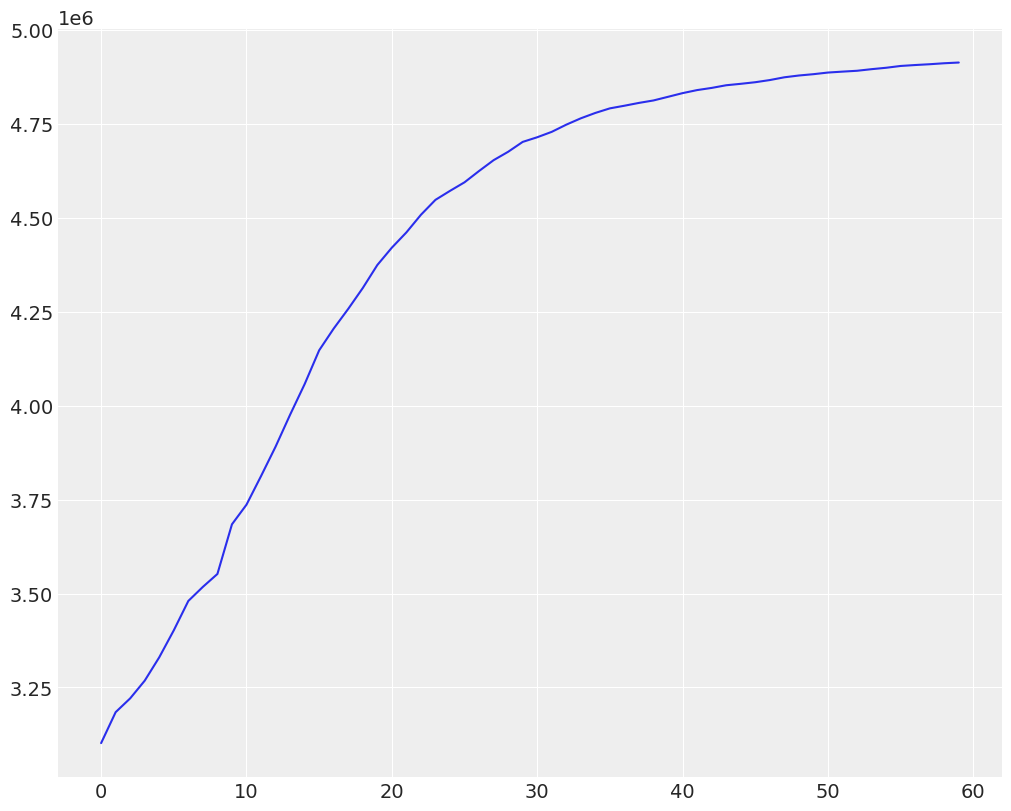

In [5]:
plt.figure(figsize=(10, 8))
plt.plot(new_york_pandemic.days_count, new_york_pandemic.Confirmed)

In [6]:
t = new_york_pandemic.days_count.values
confirmed = new_york_pandemic.Confirmed.values

with pm.Model() as model_exp1:
    # Intercept
    a = pm.Normal("a", mu=0, sigma=100)

    # Slope
    b = pm.Normal("b", mu=0.3, sigma=0.3)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Error term
    eps = pm.HalfNormal("eps", 100)

    # Likelihood
    pm.Normal("obs", mu=growth, sigma=eps, observed=confirmed)

In [7]:
with model_exp1:
    prior_pred = pm.sample_prior_predictive()

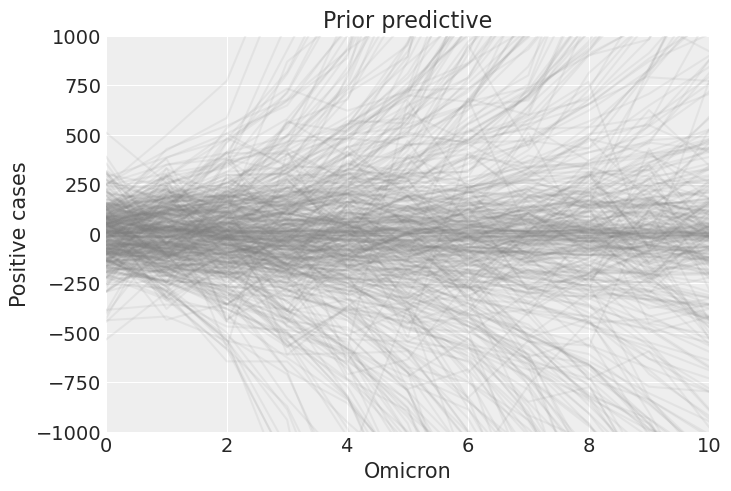

In [8]:
fig, ax = plt.subplots()
ax.plot(prior_pred["obs"].T, color="0.5", alpha=0.1)
ax.set(
    ylim=(-1000, 1000),
    xlim=(0, 10),
    title="Prior predictive",
    xlabel="Omicron",
    ylabel="Positive cases",
);

In [11]:
t = new_york_pandemic.days_count.values
confirmed = new_york_pandemic.Confirmed.values

with pm.Model() as model_exp2:
    # Intercept
    a = pm.Normal("a", mu=3_000_000, sigma=25_000)

    # Slope
    b = pm.Normal("b", mu=0.3, sigma=0.1)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Likelihood
    pm.NegativeBinomial(
        "obs", growth, alpha=pm.Gamma("alpha", mu=6, sigma=1), observed=confirmed
    )

In [12]:
with model_exp2:
    prior_pred = pm.sample_prior_predictive()

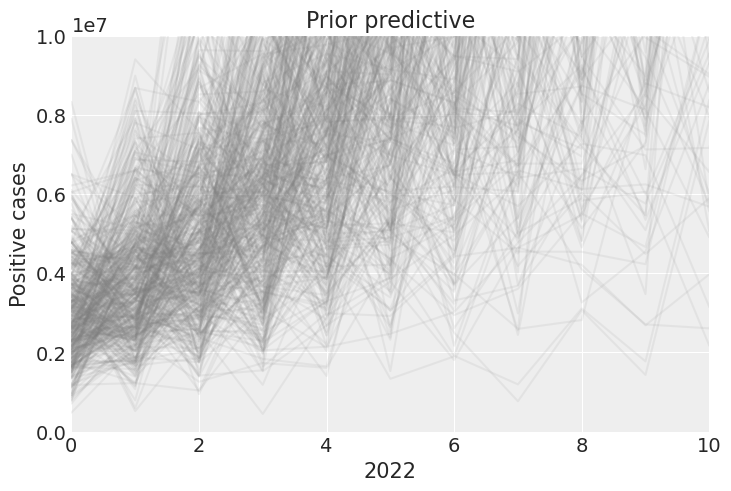

In [13]:
fig, ax = plt.subplots()
ax.plot(prior_pred["obs"].T, color="0.5", alpha=0.1)
ax.set(
    ylim=(-100, 10_000_000),
    xlim=(0, 10),
    title="Prior predictive",
    xlabel="2022",
    ylabel="Positive cases",
);

In [14]:
t = new_york_pandemic.days_count.values
confirmed = new_york_pandemic.Confirmed.values

with pm.Model() as model_exp3:
    # Intercept
    a = pm.TruncatedNormal("a", mu=3_000_000, sigma=25_000, lower=3_000_000)

    # Slope
    b = pm.TruncatedNormal("b", mu=0.3, sigma=0.1, lower=0)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Likelihood
    pm.NegativeBinomial(
        "obs", growth, alpha=pm.Gamma("alpha", mu=6, sigma=1), observed=confirmed
    )

In [15]:
with model_exp3:
    prior_pred = pm.sample_prior_predictive()

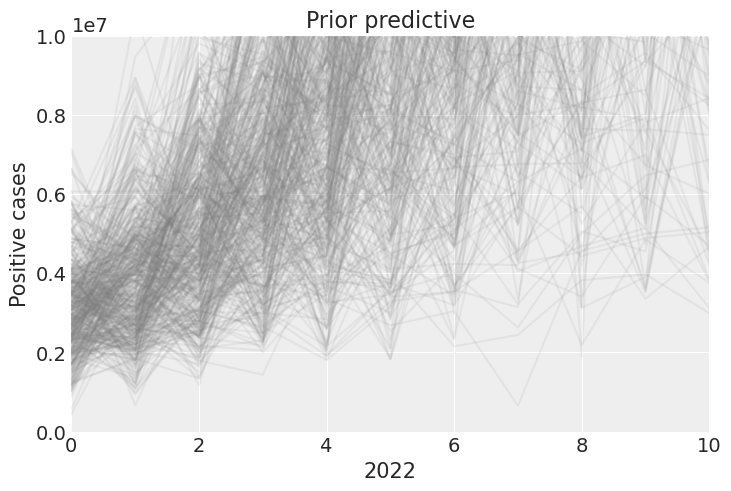

In [16]:
fig, ax = plt.subplots()
ax.plot(prior_pred["obs"].T, color="0.5", alpha=0.1)
ax.set(
    ylim=(-100, 10_000_000),
    xlim=(0, 10),
    title="Prior predictive",
    xlabel="2022",
    ylabel="Positive cases",
);

In [17]:
with pm.Model() as logistic_model:
    
    t_data = pm.Data("t", new_york_pandemic.days_count.values)
    confirmed_data = pm.Data("confirmed", new_york_pandemic.Confirmed.values)

    # Intercept
    intercept = pm.TruncatedNormal("a", mu=3_000_000, sigma=25_000, lower=3_000_000)

    # Slope
    b = pm.TruncatedNormal("b", mu=0.3, sigma=0.1, lower=0)

    carrying_capacity = pm.Uniform("carrying_capacity", lower=1_000_000, upper=10_000_000)
    # Transform carrying_capacity to a
    a = carrying_capacity / intercept - 1

    # Logistic
    growth = carrying_capacity / (1 + a * pm.math.exp(-b * t_data))

    # Likelihood
    pm.NegativeBinomial(
        "obs", growth, alpha=pm.Gamma("alpha", mu=6, sigma=1), observed=confirmed_data
    )
    
    trace_logistic_us = pm.sample(**sampler_kwargs)
    
    trace_logistic_us.extend(az.from_pymc3(posterior_predictive=pm.sample_posterior_predictive(trace_logistic_us)))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, carrying_capacity, b, a]


/Users/xianyouli/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/xianyouli/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/xianyouli/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparam

In [18]:
with logistic_model:
    prior_pred = pm.sample_prior_predictive()

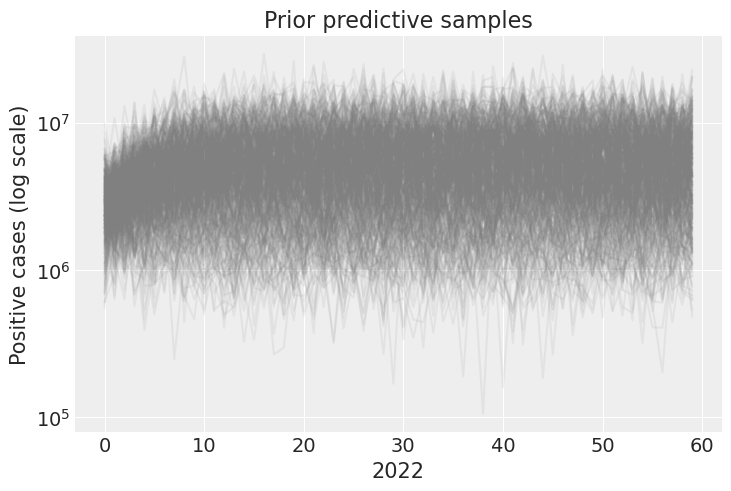

In [19]:
fig, ax = plt.subplots()
ax.plot(prior_pred["obs"].T, color="0.5", alpha=0.1)
ax.set(
    title="Prior predictive samples",
    xlabel="2022",
    ylabel="Positive cases (log scale)",
    yscale="log",
);

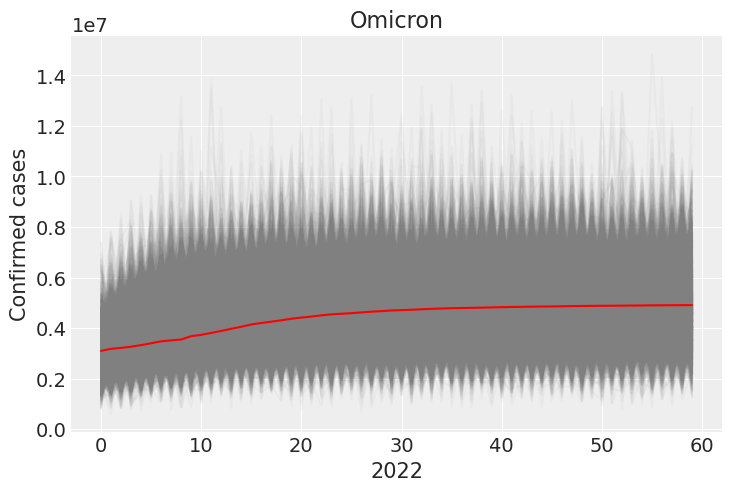

In [20]:
fig, ax = plt.subplots()
ax.plot(trace_logistic_us.posterior_predictive["obs"].values.squeeze().T, color="0.5", alpha=0.05)
ax.plot(new_york_pandemic.Confirmed.values, color="r")
ax.set(xlabel="2022", ylabel="Confirmed cases", title='Omicron');